In [1]:
from collections.abc import Generator, Callable
from pathlib import Path
import typing
from typing import Any, TypeAlias
import pandas as pd
import numpy as np
import datetime as dt
import re
from functools import partial, reduce
from tqdm import tqdm
from IPython.display import (
    display, # type: ignore[reportUnknownVariableType]
    Markdown,
)

import importlib

from config.fastf1 import fastf1
from config import config
import src.data.constants as dataset_constants
importlib.reload(dataset_constants);
import src.data.loader
importlib.reload(src.data.loader);
from src.data.loader import stream_ndjson, load_submissions_df, load_comments_df
from src.data.preprocessing import concatenate_submissions_and_comments

from src.utils import (
    temporary_pandas_options,
    display_full_dataframe,
    hide_index,
    compose,
)
from src import utils
utils.set_random_seeds()
DEVICE = utils.get_device()

import logging
logging.getLogger('fastf1').setLevel(logging.WARNING)

PyTorch version: 2.5.1+cpu
CUDA available: False
No GPU available, using CPU


# Load data and find submissions related to steward decisions

In [2]:
f1_submissions_df = load_submissions_df(
    dataset_constants.RawFile.FORMULA1_SUBMISSIONS,
    columns=dataset_constants.DEFAULT_SUBMISSION_COLUMNS | {'permalink', 'post_hint', 'link_flair_text'},
)                                  

f1_comments_df = load_comments_df(
    dataset_constants.RawFile.FORMULA1_COMMENTS,
    columns=dataset_constants.DEFAULT_COMMENT_COLUMNS | {'link_id'},
)

In [3]:
f1_comments_df = f1_comments_df[~f1_comments_df['body'].isin({'[removed]', '[deleted]'})]

In [4]:
# TODO: testing purposes
f1_submissions_df['permalink'] = 'www.reddit.com' + f1_submissions_df['permalink']

In [5]:
steward_decision_related_words = {
    'penalty', 'steward', 'decision', 'appeal', 'review', 'ruling', 'investigation', 'regulation',
    'seconds', 'sec', 
    'collision', 'crash', 'incident', 'overtake', 'virtual safety car', 'blocking', 'brake test', 'contact',
    'red flag', 'yellow flag', 
    'controversial', 'rigged', 'corrupt', 'bias', 'protest', 'FIA', 'document', 'infringement'}

# Manually exclude some posts unrelated to steward decisions
excluded_submission_ids = {
    'vdr1c6',
    'w7z5aj',
    'wf87e0',
    'x1zd5z',
    'x3y140',
}

words_regex = ''.join(fr'\b{word}\b|' for word in steward_decision_related_words)[:-1]
steward_decision_pattern = re.compile(words_regex, flags=re.IGNORECASE)

relevant_flairs = {':post-technical: Technical', ':post-news: News'}

has_related_words = f1_submissions_df['title'].apply(lambda title: steward_decision_pattern.search(title) is not None)
has_relevant_flairs = f1_submissions_df['link_flair_text'].isin(relevant_flairs)
is_image_post = f1_submissions_df['post_hint'] == 'image'
is_included = ~f1_submissions_df['id'].isin(excluded_submission_ids) 

steward_decision_submissions_df = f1_submissions_df[has_related_words & has_relevant_flairs & is_image_post & is_included].copy()

with display_full_dataframe():
    print(len(steward_decision_submissions_df))
    display(steward_decision_submissions_df.head(2))

63


,id,title,link_flair_text,selftext,score,author,created_utc,permalink,post_hint,gilded
2401,vala14,Explanation for Nicholas Latifi's 10 second stop-and-go penalty,:post-news: News,,299,chu1u,2022-06-12 12:48:21,www.reddit.com/r/formula1/comments/vala14/explanation_for_nicholas_latifis_10_second/,image,0
2416,vald3s,Explanation for Nicholas Latifi's 5 second penalty for ignoring blue flags,:post-news: News,,192,chu1u,2022-06-12 12:53:23,www.reddit.com/r/formula1/comments/vald3s/explanation_for_nicholas_latifis_5_second_penalty/,image,0


In [6]:
submission_link_id = f't3_xtqa50'
comments_df = f1_comments_df[f1_comments_df['link_id'] == submission_link_id]
print(len(comments_df))


376


# Discretization of continuous sentiment function

In [7]:
def to_sentiment_category(sentiment: float) -> str:
    if sentiment >= 0.05:
        return 'Positive'
    elif sentiment <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

### VADER SENTIMENT ANALYSIS

In [8]:
# TODO: testing
steward_decision_submissions_df = load_submissions_df(dataset_constants.RawFile.FORMULA1_SUBMISSIONS, partial(stream_ndjson, limit=100))

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
individual_vader_sentiments = []

for index, steward_decision_submission in steward_decision_submissions_df.iterrows():
    submission_link_id = f't3_{steward_decision_submission['id']}'
    comments_df = f1_comments_df[f1_comments_df['link_id'] == submission_link_id].copy()

    if comments_df.empty:
        steward_decision_submissions_df.loc[index, 'average_sentiment_vader'] = np.nan
        continue
    
    NOEMER = np.abs(comments_df['score']).sum()
    
    if NOEMER == 0:
        steward_decision_submissions_df.loc[index, 'average_sentiment_vader'] = np.nan
        continue

    comments_df.loc[:, 'compound'] = comments_df['body'].apply(
        lambda text: analyzer.polarity_scores(text)['compound']
    )   #creates a data series with a score (float) given an input comment

    sentiment = (comments_df['compound'] * comments_df['score']).sum() / NOEMER
    steward_decision_submissions_df.loc[index, 'average_sentiment_vader'] = sentiment

    individual_vader_sentiments.append(sentiment)

# print(individual_vader_sentiments[:10])

with display_full_dataframe():
    display(steward_decision_submissions_df.head(2))



,id,title,score,author,created_utc,selftext,gilded,average_sentiment_vader
0,v2fbpg,[Discussion] Could professional ESports drivers drive a real F1 car? How realistic are the sims?,1,[deleted],2022-06-01 12:00:41,[removed],0,NaN
1,v2fh6w,Questions concerning Alonso's future,2,Doomaster14,2022-06-01 12:07:50,[removed],0,0.025293


In [11]:
# # TOOD: vectorize if efficiency is needed
# steward_decision_submissions_df['submission_link_id'] = 't3_' + steward_decision_submissions_df['id']

# filtered_comments_df = f1_comments_df[
#     f1_comments_df['link_id'].isin(steward_decision_submissions_df['submission_link_id'])
# ].copy()

# filtered_comments_df['compound'] = filtered_comments_df['body'].apply(
#     lambda text: analyzer.polarity_scores(text)['compound']
# )

# def calculate_weighted_sentiment(group):
#     NOEMER = np.abs(group['score']).sum()
#     if NOEMER == 0:
#         return np.nan
#     return (group['compound'] * group['score']).sum() / NOEMER

# average_sentiment = filtered_comments_df.groupby('link_id').apply(calculate_weighted_sentiment)

# steward_decision_submissions_df['average_sentiment_vader'] = \
#     steward_decision_submissions_df['submission_link_id'].map(average_sentiment)

# steward_decision_submissions_df.drop(columns=['submission_link_id'], inplace=True)


### BERT SENTIMENT ANALYSIS

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model.to(DEVICE);

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

def BERT_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment_score = torch.argmax(logits, dim=1).item()  # 0: negative, 1: neutral, 2: positive
    return (sentiment_score - 1) #-1: negative, 0: neutral, 1: positive

individual_bert_sentiments = []

for index, steward_decision_submission in steward_decision_submissions_df.iterrows():
    submission_link_id = f't3_{steward_decision_submission['id']}'
    comments_df = f1_comments_df[f1_comments_df['link_id'] == submission_link_id].copy()

    if comments_df.empty:
        steward_decision_submissions_df.loc[index, 'average_sentiment_bert'] = np.nan
        individual_bert_sentiments.append(sentiment)  # Store NaN in the list
        continue
    
    NOEMER = np.abs(comments_df['score']).sum()
    
    if NOEMER == 0:
        steward_decision_submissions_df.loc[index, 'average_sentiment_bert'] = np.nan
        individual_bert_sentiments.append(sentiment)  # Store NaN in the list
        continue

    comments_df.loc[:, 'compound'] = comments_df['body'].apply(BERT_sentiment)
        # lambda text: analyzer.polarity_scores(text)['compound']
        # bert induced sentiment

    sentiment = (comments_df['compound'] * comments_df['score']).sum() / NOEMER
    steward_decision_submissions_df.loc[index, 'average_sentiment_bert'] = sentiment

    individual_bert_sentiments.append(sentiment)  # Append BERT sentiment to list

#  with display_full_dataframe():
    # display(steward_decision_submissions_df)
    # display(steward_decision_submissions_df['average_sentiment_bert'])

In [14]:
with display_full_dataframe():
    display(steward_decision_submissions_df)

,id,title,score,author,created_utc,selftext,gilded,average_sentiment_vader,average_sentiment_bert
0,v2fbpg,[Discussion] Could professional ESports drivers drive a real F1 car? How realistic are the sims?,1,[deleted],2022-06-01 12:00:41,[removed],0,NaN,NaN
1,v2fh6w,Questions concerning Alonso's future,2,Doomaster14,2022-06-01 12:07:50,[removed],0,0.025293,-0.395280
2,v2fmeh,Verstappen now has as many poles as Leclerc - but six times as many wins | 2022 Monaco Grand Prix stats and facts,1393,motorace_addict,2022-06-01 12:15:14,,0,0.354951,0.097642
3,v2frea,Perez wins as Red Bull delivers race strategy blow to Ferrari - Mika Häkkinen’s thoughts on the Monaco Grand Prix,161,MrTuxedo1,2022-06-01 12:23:16,,0,0.310102,0.009479
4,v2ft61,"The ""new"" qualifying since (I think 2021?) 2021 is way too short for most Tracks IMO.",0,[deleted],2022-06-01 12:25:54,[deleted],0,-0.139927,-0.374126
5,v2fv0f,[Joe Saward] Sources saying that Peter Bayer has gone from his position as head of F1 at the FIA...checking now,451,jovanmilic97,2022-06-01 12:28:38,,0,0.193211,-0.282840
6,v2g0rg,Happy 75th Birthday to Rob Dennis,1,[deleted],2022-06-01 12:36:38,[deleted],0,-0.038850,-0.500000
7,v2g1tr,Happy 75th Birthday to Ron Dennis,1527,MrTuxedo1,2022-06-01 12:38:09,,0,0.069107,0.284192
8,v2g2ru,"Aston Martin Aramco Cognizant on Instagram: “This #PrideMonth, we will be shining a light on the importance of #allyship in motorsport and the LGBTQ+ community. Join us and our…”",1,boitcon,2022-06-01 12:39:36,,0,0.786200,0.000000
9,v2g6qb,[FIA] The FIA announces the departure of Peter Bayer and the interim appointment of Shaila-Ann Rao,597,mousehart,2022-06-01 12:45:25,,0,0.269862,-0.195229


In [15]:
# MEAN ABSOLUTE ERROR
print(
    np.abs(steward_decision_submissions_df['average_sentiment_bert'] - steward_decision_submissions_df['average_sentiment_vader']).sum() \
    / len(steward_decision_submissions_df.index)
)

0.41759041938379005


In [16]:
display(steward_decision_submissions_df.columns)


Index(['id', 'title', 'score', 'author', 'created_utc', 'selftext', 'gilded',
       'average_sentiment_vader', 'average_sentiment_bert'],
      dtype='object')

# VALIDATION
# 1. CATEGORIZATIONI AGREEMENT METRIC - Cohen's Kappa

In [17]:
from sklearn.metrics import cohen_kappa_score

# Vader_sentiments = steward_decision_submissions_df['average_sentiment_vader']
# Bert_sentiments = steward_decision_submissions_df['average_sentiment_bert']

vader_sentiment_labels = np.array([to_sentiment_category(x) for x in individual_vader_sentiments])
bert_sentiment_labels = np.array([to_sentiment_category(y) for y in individual_bert_sentiments])

COHEN_KAPPA = cohen_kappa_score(vader_sentiment_labels, bert_sentiment_labels)
print(f"Cohen's Kappa: {COHEN_KAPPA:.2f}")

# Kappa > 0.75 is a Strong agreement
# Kappa = 0.4 - 0.75 is a Moderate agreement
# Kappa < 0.4 is a Weak agreement

ValueError: Found input variables with inconsistent numbers of samples: [81, 100]


# 2. BIAS DETECTION METRIC - Bland-Altman plot

In [ ]:
# calculate systematic biases between VADER and BERT sentiment analysis

import seaborn as sns
import matplotlib.pyplot as plt


mean_scores = (np.array(individual_vader_sentiments) + np.array(individual_bert_sentiments)) / 2
diff_scores = np.array(individual_vader_sentiments) - np.array(individual_bert_sentiments)

# Create a scatter plot for the Bland-Altman analysis
sns.scatterplot(x=mean_scores, y=diff_scores)
plt.axhline(0, color='red', linestyle='dashed')  # No bias line
plt.xlabel("Mean Sentiment Score")
plt.ylabel("VADER - BERT Sentiment Score Difference")
plt.title("Bland-Altman Plot")
plt.show()
# patterns indicate bias
# if most points are close to 0, the models mostly agree

In [19]:
import json
import glob

ground_truth = {}                                                               #dictionary for easier later comparison
ndjson_files_ground_truth = glob.glob("/GROUND_TRUTH_LABELS.ndjson")

for file in ndjson_files_ground_truth:
    with open(file, "r") as f:
        for line in f:
            entry = json.loads(line)
            ground_truth[entry["comment_id"]] = entry["sentiment"]


print(list(ground_truth.items())[:5])

vader_labels = to_sentiment_category(individual_vader_sentiments)
bert_labels = to_sentiment_category(individual_bert_sentiments)


#comparison lists
y_true = [ground_truth[comment_id] for comment_id in ground_truth]
y_vader = [vader_labels[comment_id] for comment_id in ground_truth]
y_bert = [bert_labels[comment_id] for comment_id in ground_truth]

# check if works
print("Ground Truth:", y_true[:5])
print("VADER Predictions:", y_vader[:5])
print("BERT Predictions:", y_bert[:5])



[]


TypeError: '>=' not supported between instances of 'list' and 'float'

# EXTRINSIC VALIDATION - CONFUSION MATRIX

attempt 1

Sample Ground Truth Data: [('iqr5d98', 'Neutral'), ('iqr5dcx', 'Positive'), ('iqr5dr3', 'Positive'), ('iqr5e0k', 'Neutral'), ('iqr5ef7', 'Positive')]
Sample VADER Predictions: ['Neutral', 'Positive', 'Positive', 'Negative', 'Positive']
Sample BERT Predictions: ['Positive', 'Negative', 'Positive', 'Neutral', 'Negative']
Total Common Comments: 756


ValueError: Found input variables with inconsistent numbers of samples: [756, 81]

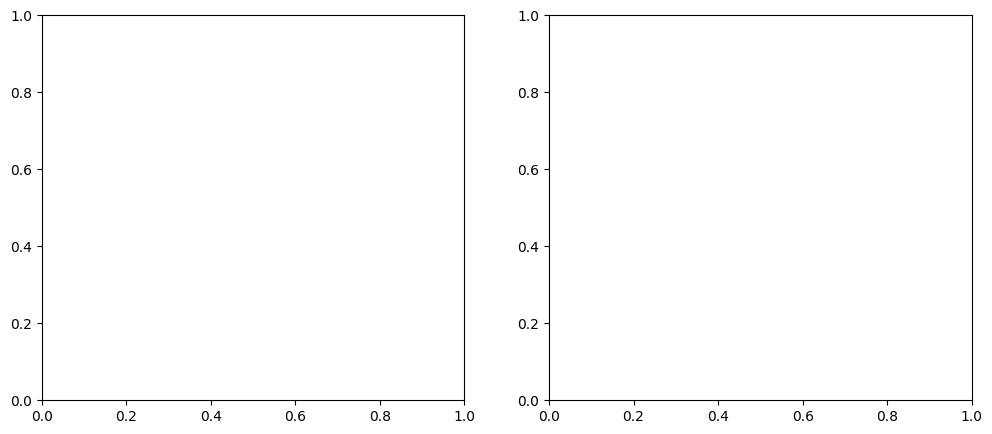

In [35]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score

ground_truth = {}
path = os.path.join("GROUND_TRUTH_LABELS", "*.ndjson")
ndjson_files_ground_truth = glob.glob(path)

# Load Ground Truth Labels
# ground_truth = {}  # Dictionary for easier comparison
# ndjson_files_ground_truth = glob.glob("/GROUND_TRUTH_LABELS/*.ndjson")  # Adjust path as needed

for file in ndjson_files_ground_truth:
    with open(file, "r") as f:
        for line in f:
            entry = json.loads(line)
            ground_truth[entry["comment_id"]] = entry["sentiment"]

print("Sample Ground Truth Data:", list(ground_truth.items())[:5])

# Convert VADER and BERT sentiment scores to labels (Positive, Neutral, Negative)
vader_labels = [to_sentiment_category(sentiment) for sentiment in individual_vader_sentiments]
bert_labels = [to_sentiment_category(sentiment) for sentiment in individual_bert_sentiments]

print("Sample VADER Predictions:", vader_labels[:5])
print("Sample BERT Predictions:", bert_labels[:5])

# Assuming the comment IDs are in the same order in ground_truth as in the sentiment lists
common_comment_ids = set(ground_truth.keys())  

y_true = [ground_truth[comment_id] for comment_id in common_comment_ids]
y_vader = vader_labels[:len(y_true)]  # Ensure same length 
y_bert = bert_labels[:len(y_true)]  # Ensure same length 

print(f"Total Common Comments: {len(common_comment_ids)}")

# Step 3.1: Compute and Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_pred, title) in zip(axes, [(y_vader, "VADER"), (y_bert, "BERT")]):
    cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Neutral", "Negative"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Positive", "Neutral", "Negative"],
                yticklabels=["Positive", "Neutral", "Negative"], ax=ax)
    ax.set_title(f"Confusion Matrix: {title}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [34]:
print("Sample VADER Sentiment Labels:", vader_labels[:5])
print("Sample BERT Sentiment Labels:", bert_labels[:5])

print("Sample Ground Truth Labels:", list(ground_truth.values())[:5])

print("Found NDJSON files:", ndjson_files_ground_truth)

import os
print("Current working directory:", os.getcwd())



print(os.listdir('GROUND_TRUTH_LABELS'))  # This should list the files in the folder



import glob
ndjson_files_ground_truth = glob.glob("GROUND_TRUTH_LABELS/*.ndjson")  # or use absolute path here
print("Found NDJSON files:", ndjson_files_ground_truth)



file_path = "GROUND_TRUTH_LABELS/labeled_comments_xtqa50.ndjson"  # Replace with actual filename
try:
    with open(file_path, "r") as f:
        print(f.readline())  # Try reading the first line
except FileNotFoundError:
    print(f"File {file_path} not found.")




Sample VADER Sentiment Labels: ['Neutral', 'Positive', 'Positive', 'Negative', 'Positive']
Sample BERT Sentiment Labels: ['Positive', 'Negative', 'Positive', 'Neutral', 'Negative']
Sample Ground Truth Labels: []
Found NDJSON files: ['GROUND_TRUTH_LABELS\\labeled_comments_xtqa50.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ybsvmi.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ybt2gv.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ybtg67.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ybviej.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ybvyae.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_yc1nol.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_yhqzpd.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ythv2y.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ytk2c6.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_ytkj0e.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_yuc0d1.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_yuc2hv.ndjson', 'GROUND_TRUTH_LABELS\\labeled_comments_yuc331.ndjson

attempt 2

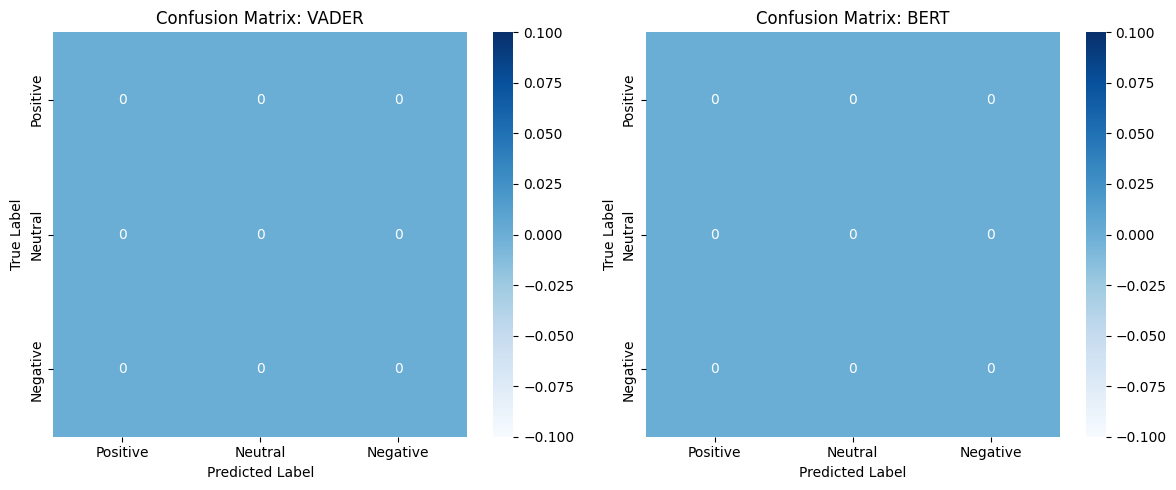

In [40]:
import json
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load Ground Truth Labels
ground_truth = {}
path = os.path.join("GROUND_TRUTH_LABELS", "*.ndjson")
ndjson_files_ground_truth = glob.glob(path)

for file in ndjson_files_ground_truth:
    with open(file, "r") as f:
        for line in f:
            entry = json.loads(line)
            ground_truth[entry["comment_id"]] = entry["sentiment"]

# Simulated VADER and BERT predictions (replace these with actual predictions)
individual_vader_sentiments = {"Negative": -1, "Neutral": 0, "Positive": 1}
individual_bert_sentiments = {"Negative": -1, "Neutral": 0, "Positive": 1}

# Convert sentiment scores to labels
vader_labels = {k: to_sentiment_category(v) for k, v in individual_vader_sentiments.items()}
bert_labels = {k: to_sentiment_category(v) for k, v in individual_bert_sentiments.items()}

# Find common comment IDs
common_comment_ids = set(ground_truth.keys()) & set(vader_labels.keys()) & set(bert_labels.keys())

y_true = [ground_truth[cid] for cid in common_comment_ids]
y_vader = [vader_labels[cid] for cid in common_comment_ids]
y_bert = [bert_labels[cid] for cid in common_comment_ids]

# Generate Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (y_pred, title) in zip(axes, [(y_vader, "VADER"), (y_bert, "BERT")]):
    cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Neutral", "Negative"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Positive", "Neutral", "Negative"],
                yticklabels=["Positive", "Neutral", "Negative"], ax=ax)
    ax.set_title(f"Confusion Matrix: {title}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()
